# Lab 8: Applications of Markov chains and graphs

In this lab we will be looking at some applications of Markov chains and graphs, namely, the page rank algorithm, an introduction to statistical inference with a Markov model, and cache replacement policies.

Below is the code to import the modules we will be using throughout this lab.

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
import csv as csv
import networkx as nx
import random
import math
print ("Modules Imported!")

# Markov chain object similar to random variable objects in scipy.stats (st)

class Markov_chain:
    def __init__(self, P, pi0):   # The transition probability matrix and initial distribution are passed
        self.P = P 
        self.pi0 = pi0
        self.n=np.size(pi0)
        if np.shape(P) != (self.n,self.n):
            print ("Error: Shape of P doesn't match pi0")
   
    def rvs(self,T):     # produce a length T segment of variates of the random process
        X = [np.random.choice(self.n, p=self.pi0)]  # p is a needed input for np.random.choice()
        for t in range(1,T):
            X.append(np.random.choice(self.n, p=self.P[X[t-1],:])) 
        return np.array(X)
    
    def pi(self,t):    # produce probability distribution at time t
        pi_new=self.pi0
        for s in range(t):
            pi_new = np.dot(pi_new, self.P)    # one step update of probability distribution
        return pi_new
print ("Markov_chain class defined")

Modules Imported!
Markov_chain class defined


## Page Rank Algorithm

Now that we see how to generate, manipulate, and plot graphs, we can investigate Page's ranking algorithm for webpages, which uses a Markov chain based on the graphical structure of the set of web pages on the Internet.  Suppose now that we have a directed graph that represents a set of web pages; a link from one webpage to another designates that the first webpage has a hyperlink to the second webpage.   Then webpages that have more incoming edges should have a higher rank.   If the webpages pointing into a particular webpage have higher ranks, then the ranking of the webpage pointed to should be even higher.    These ideas are encapsulated in the pagerank algorithm, which is based on a Markov chain with the following one-step transition probability matrix:  
$p_{i,j} = \frac{dA_{i,j}}{\mbox{out_degree}(i)} +  \frac{1-d}{n}.$  Here $A$ represents the adjacency matrix of the graph, so that $A_{i,j}=1$ if there is an edge from $i$ to $j,$  and $A_{i,j}=0$ otherwise.
Originally Google used $d$=85%. That is, if the current state is $i$, then a biased coin is flipped with heads showing with probability $d.$   If heads shows, then the next state is one of the nodes pointed to by node $i,$  with all choices having equal probability.  If tails shows, the next node is selected at random from among all nodes in the graph, each with equal probability.  There is a slight problem about what to do if a node has outdegree zero because in that case the first term is not well defined; you will be asked to address this problem.

The following code generates a random directed graph, and then ranks the popularity of the nodes in the graph using the pagerank method. The code uses the adjacency matrix of the graph, mentioned above. Instead of using the equilibrium distribution for the Markov chain, we use the probability distribution of the chain after 100 time steps.  The row sums of the adjacency matrix give the outdegrees.  One way to think about it is that the Markov chain models a person randomly clicking through webpages.  Pages are ranked according to the probability distribution of which page the person has reached after 100 time steps.

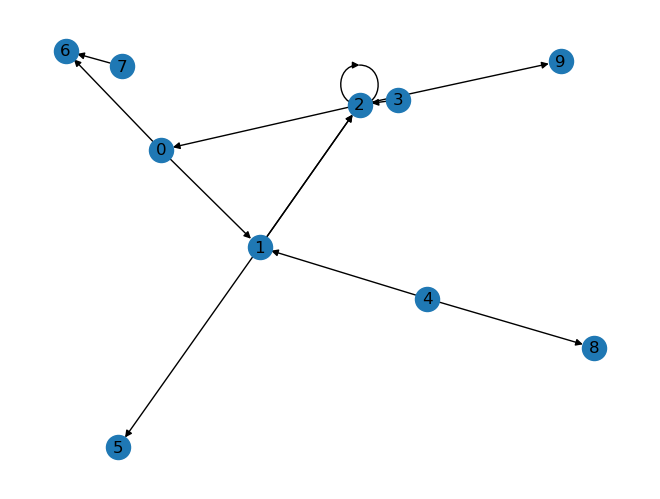

rank vector [ 6.  7.  5.  9. 10.  3.  1.  8.  4.  2.]
Simulated state sequence:  [8 1 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 1 2 2 0 0 1 1 5 5 5 5 5 5 5 6 1 5 5 5
 5 5 5 5 5 5 5 2 2 9 9 9 9 9 2 0 0 1 8 8 8 8 8 5 5 5 5 5 5 5 2 3 3 3 2 9 9
 9 9 9 9 9 9 5 5 5 5 5 5 5 1 1 1 3 3 3 2 2 9 9 9 8 8]


In [49]:
# A simulation of the pagerank algorithm
#import networkx as nx

# Create a random directed graph object and plot it:
G = nx.scale_free_graph(10, alpha=0.2, beta=0.4, gamma=0.4)   
nx.draw(G,with_labels=1)
plt.show()

# Next we add identity matrix to the adjacency matrix, which
# is equivalent to adding a self loop to each node.
# This is a way to make the out degree of every node nonzero.
# nx returns adjacency matrix in Scipy sparse format; toarray() converts to dense format
n = G.number_of_nodes()
A = np.array(nx.adjacency_matrix(G).toarray()) + np.identity(n)
          
# Note: The random "scale free" graph here allows more than one edge between two nodes. Therefore, you may see entries 
# larger than one in matrix A. That is OK, it just means that are more than one hyperlinks from one website to another. 
    
d=0.85    # continuation parameter for pagerank
 # Next, define transition probability matrix for page rank algoritm
P=d*A/A.sum(axis=1)[:,np.newaxis]  + ((1-d)/n)*np.ones((n,n))   # This line of code is crucial to answer part 2 of Problem 1.
pi0=np.ones((n))/n 

markov=Markov_chain(P, pi0)  # Uses Markov_chain class defined in first code cell above
    
print ("rank vector", st.rankdata(-markov.pi(100)))  # larger probabilities map to smaller numbers
print ("Simulated state sequence: ", markov.rvs(100))   # Prints simulation of Markov chain

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 1:</SPAN>** Run the above code and examine the output for a few graphs.  The nodes are numbered from 0 to n-1, and the rank vector gives the popularity rank for each node.  For example, the position of the one in the rank vector denotes the most popular node.
<ol><li> Qualitatively comment on the graphs. Where does it appear that the most popular nodes are?</li>
<li> The above code uses a particular method to deal with nodes that have no neighbors.   Perhaps it is not fair, because it rewards nodes that have no links to other nodes.   Propose and implement another method for dealing with nodes that have no outgoing links that you think is better.  Explain why you think your method is better.</li>

__Answer:__ The most popular nodes tend to be the ones that have a singular connection to a popular node or no outgoing connections. This makes sense because to maximize the probability equation you have to have a low number of edges points out to keep the user on your website. The method I am choosing to do it brute checking if the node has no outgoing edge. If it doesn't then we only add the (1-d)/n to the probablity for a specific edge. This makes it so that nodes without links are not rewarded. The flaw to this method is that there a large amount of ties and it is $O(n^2 )$ run time which is not good if we have thousands of websites.

In [50]:
# Your code here
A2 = np.array(nx.adjacency_matrix(G).toarray())
P = np.zeros((n,n))

for i in range(A2.shape[0]):
    check = np.sum(A2[i,:])
    for j in range(A2.shape[1]):
        if(check == 0):
            P[i,j] = ((1-d)/n)
        else:
            P[i,j] = d*A[i,j]/check  + ((1-d)/n)
    
pi0=np.ones((n))/n 

markov=Markov_chain(P, pi0)
print ("rank vector", st.rankdata(-markov.pi(100)))

rank vector [2.  4.  1.  6.  9.5 8.  3.  7.  9.5 5. ]


**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 1</SPAN>**

## Some statistical inference for Markov chains

To prepare for statistical inference for Markov chains, we begin by considering the maximum likelihood (ML) estimator for the distribution of a  sequence of independent, identically distributed discrete random variables.   Specifically, suppose p=[p[0], . . . , p[n-1]] is a probability vector for random variables taking values in {0,1, . . . , n-1}.   That is, p[i] is the probability a generated random variable is equal to i.
Suppose that you don't know what the vector p is, but you observe a sequence of T independent random variables that were generated using p.  How would you estimate p?   A natural guess is to use p_hat[i]=(number of samples equal to i)/T.   Basically, p_hat is just a normalized histogram of p.  It can be shown that this choice of p_hat is the maximum likelihood (ML) estimator of p.  (The usual proof is to use a Lagrange multiplier for the constraint p[0]+ . . . + p[n-1]=1.)  Try running the following code several times and see how well p_hat approximates p.  If T is increased the estimates become more accurate.

In [55]:
p=np.array([0.2,0.2,0.4,0.2])
c=np.arange(np.size(p))
Xcstm = st.rv_discrete(values = (c,p))
T=100  # Number of values generated
values = Xcstm.rvs(size = T)
# print (values)
p_hat=np.bincount(values,minlength=np.size(p))/1./np.size(values)
print ("    p:", p)
print ("p_hat:", p_hat,"(estimate of p based on ", T, "values)")
print ("Sum of squared errors:", np.linalg.norm(p-p_hat)**2.)  # the norm method calculates the 2-norm by default

    p: [0.2 0.2 0.4 0.2]
p_hat: [0.21 0.19 0.4  0.2 ] (estimate of p based on  100 values)
Sum of squared errors: 0.00019999999999999982


The same principle can be used to estimate the transition probability matrix for a Markov chain.  
<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 2:</SPAN>**   Generate a length T simulation of a four state Markov chain using some initial distriubution and some 4x4 transition probability matrix P.  Select P to have some zeros in it, but make sure the process can eventually get to any state starting from any other state.  Then, taking the generated sequence as the only input, generate an estimate, P_hat, of the matrix P.   Your estimator should be more accurate for larger values of T.  (Hint:  For a given state i, the ith row of P is the probability distribution of the next state, given the current state is i.  So to estimate the ith row of P, you should focus on the states that occur just after state i is visited.)

In [75]:
# Your code here
n = 4
pi0=np.ones((n))/n 
P = np.array([[0.7, 0.2, 0.0, 0.1], [0.3, 0.4, 0.2, 0.1], [0.0, 0.0, 0.6, 0.4], [0.1, 0.1, 0.8, 0.0]])
P_hat = np.zeros((n, n))

cur = np.random.choice(n, p=pi0)
trial = [cur]

for bananas in range(T - 1):
    next_ = np.random.choice(n, p=P[cur])
    trial.append(next_)
    cur = next_

for i in range(n):
    transi = [trial[j + 1] for j, state in enumerate(trial[:-1]) if state == i]
    count = np.bincount(transi, minlength=n)
    P_hat[i] = count / len(transi)

print("True P:")
print(P)
print("\nP_hat (estimate of P based on the generated sequence):")
print(P_hat)


True P:
[[0.7 0.2 0.  0.1]
 [0.3 0.4 0.2 0.1]
 [0.  0.  0.6 0.4]
 [0.1 0.1 0.8 0. ]]

P_hat (estimate of P based on the generated sequence):
[[0.57142857 0.28571429 0.         0.14285714]
 [0.18181818 0.54545455 0.09090909 0.18181818]
 [0.         0.         0.65517241 0.34482759]
 [0.04347826 0.13043478 0.82608696 0.        ]]


**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 2</SPAN>**

## Cache Replacement Policy:

A cache is used to hold information so the information can be retrieved more quickly than going through memory. Suppose you have a memory or server that holds $n$ elements and you have a cache that holds $k$ elements ($n>k$). When you want to retrieve an item, you first search through the cache. If the item is in the cache, it is considered a hit. If it's not in the cache, it's considered a miss. When a miss occurs, you have the longer process of searching for the item in memory. A key question for cache design is what items to keep in the cache? When you have a miss should you place that item in the cache?  If so, what item in the cache should you replace (i.e. drop from the cache to make room)?  Since it's unlikely the items will be uniformly searched for (some items will be more popular than others) many policies have been developed to try and maximize the liklihood that a requested item will be in the cache. A few are listed below:
<ol>
    <li> Belady's Algorithm: This is considered to be the most efficient algorithm possible. When a miss occurs, it retrieves that item and replaces an item in the cache with it. The item that's replaced is the item that will not be retrieved for the longest time in the future. It is a practically impossible algorithm because it requires knowledge of how far in the future an item will needed. </li><br>
    <li>Least Recently Used (LRU): You can think of this algorithm as a first in first out queue. When a miss occurs, that element gets retrieved from memory and gets put at the top of that queue. It replaces the item in the cache that was retrieved the longest time ago. When a hit occurs, that item gets put back to the top of the queue.</li><br>
    <li>Random Replacement (RR): This algortihm is similiar to the LRU algorithm except the miss replaces an element that was previously in the cache, selected uniformly at random.</li><br>
    <li>Least Frequently Used (LFU): In this algorithm the miss replaces the element in the cache that is the least frequently used. It's a little more complicated because you need to keep a count on the number of hits an element in the cache gets over a certain time period, or something similar. </li><br>
</ol>

Let's try and simulate the Least Recently Used policy. In your folder should be a file called all_names.csv. We are going to load this in and use it as the memory. We are also going to set up an ordered array to represent the cache. Then we're going to simulate retrievals of information based on a Zipf distribution and see what our experimental hit percentage is.

Hit Percentage: 0.354


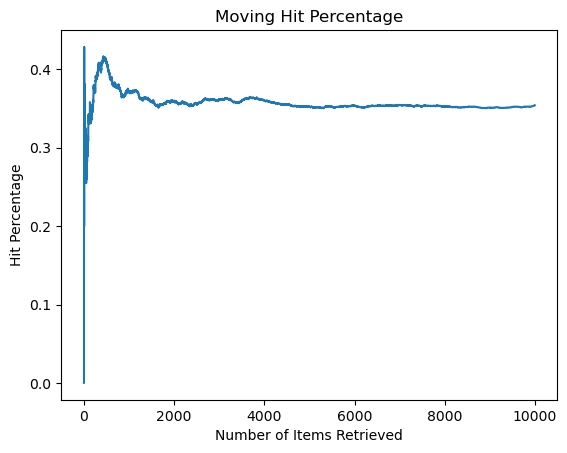

In [93]:
#Loads the CSV file
def load_file(filename):
    names = []
    try:
        f = open(filename)
        reader = csv.reader(f)
        for row in reader:
            names.append(row[0])
        f.close()
    except:
        print ('Error: Could Not Load File')
    return np.array(names)

#Creates a zipf distribution using the stats discrete module
def zipf(s, N):
    n = range(1,N+1)
    p = []
    z = 0.
    for i in n:
        temp = (1./i)**s
        p.append(temp)
        z = z+temp
    for i in range(np.size(p)): p[i]=p[i]/z
    return st.rv_discrete(name = 'Zipf', values=(n,p))

#When a hit occurs, move the hit item to the top of the list for LRU
def cache_hit(cache,item):
    # cache.index(item) is current location of item in the cache
    for i in range(cache.index(item),np.size(cache)-1):    
        cache[i] = cache[i+1]
    cache[np.size(cache)-1] = item
    return cache
    
#When a miss occurs, replace the least recently used (LRU) item
def cache_miss(cache, item):
    for i in range(np.size(cache)-1):
        cache[i]=cache[i+1]
    cache[np.size(cache)-1] = item
    return cache

#Runs the main code for the simulation
filename = 'all_names.csv'
names = load_file(filename) #This is treated as your memory
rv_zipf = zipf(1.0,np.size(names))
k = 50 #Size of the Cache
r = 10000 #Number of retrievals
hits = 0. #Keeps track of the number of hits in the cache
hit_av = [] #Keeps track of the hit average
cache = [] #List to represent the cache

# We first fill cache with k items.  We don't check for
# duplicates because if item stream is not diverse this
# step could cause infinite loop.
while np.size(cache) < k:                 
    rv = rv_zipf.rvs()-1   #Random variate from the zipf distribution
    item = names[rv]    #Item to be retrieved
    cache.append(item)
        
for i in range(r):
    rv = rv_zipf.rvs()-1   #Random variate from the zipf distribution
    item = names[rv]    #Item to be retrieved
    if item in cache:
        cache = cache_hit(cache, item)
        hits = hits+1
    else:
        cache = cache_miss(cache, item)
    hit_av.append(hits/(i+1))

plt.plot(hit_av)
plt.title('Moving Hit Percentage')
plt.xlabel('Number of Items Retrieved')
plt.ylabel('Hit Percentage')
print ('Hit Percentage:', hit_av[np.size(hit_av)-1])

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 3:</SPAN>** Use the code given above to do the following:
<ol>
<li> Create a new simulation using a random replacement policy. What is the impact on the hit percentage? Plot the moving hit percentage under this policy.</li>
<li> We used a Zipf distribution to represent the retrieval requests. It is a heavy tailed distribution with two parameters s and N. Run the given LRU simulation, but vary the s value from 0.5 to 3 in .5 increments. Plot the moving hit percentage under each of these conditions. Why might this be occuring? (The answer lies in the structure of the Zipf distribution)</li>
<li> Setting s=1.0 again for the LRU simulation, print out the cache hit rate for k=50, 100, 400, respectively.  How does the cache hit rate vary with the cache size k? Why is that?  
<li> Explain whether or not the state of the cache in this experiment can be viewed as a Markov process, both for the LRU policy and for the random replacement policy.</li>

Hit Percentage: 0.6648


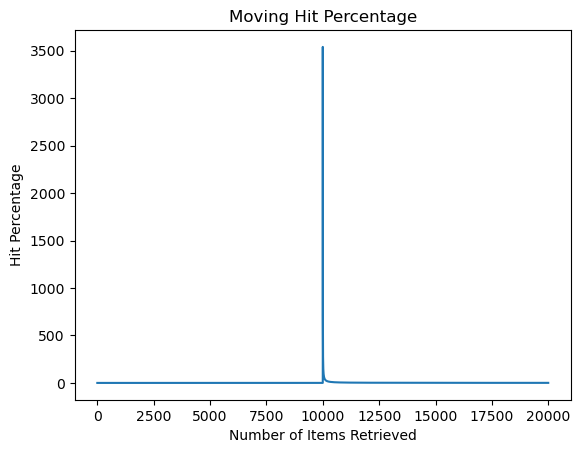

In [94]:
# Your code here (add additional code/markdown cells if necessary)
while np.size(cache) < k:                 
    rv = rv_zipf.rvs()-1   #Random variate from the zipf distribution
    item = names[rv]    #Item to be retrieved
    cache.append(item)
        
for i in range(r):
    rv = rv_zipf.rvs()-1   #Random variate from the zipf distribution
    item = names[rv]    #Item to be retrieved
    if item in cache:
        cache = cache_hit(cache, item)
        hits = hits+1
    else:
        index = np.random.randint(0, k)
        cache[index] = item
    hit_av.append(hits/(i+1))

plt.plot(hit_av)
plt.title('Moving Hit Percentage')
plt.xlabel('Number of Items Retrieved')
plt.ylabel('Hit Percentage')
print ('Hit Percentage:', hit_av[np.size(hit_av)-1])

Hit Percentage s = 0.5: 0.0247
Hit Percentage s = 1.0: 0.3589
Hit Percentage s = 1.5: 0.826
Hit Percentage s = 2.0: 0.9477
Hit Percentage s = 2.5: 0.9786
Hit Percentage s = 3.0: 0.9894


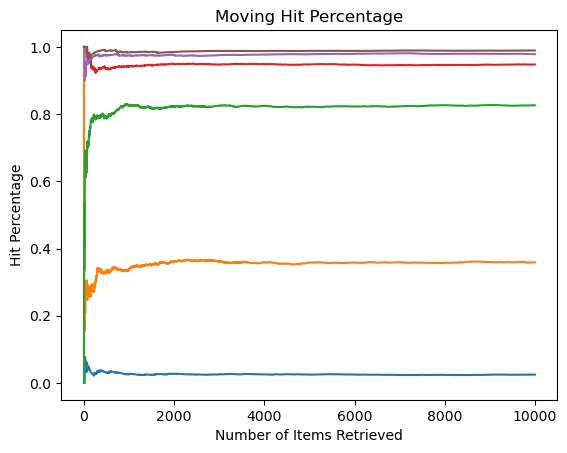

In [103]:
l1 = np.linspace(0.5, 3, 6)
for s in l1:
    rv_zipf = zipf(s,np.size(names))
    k = 50 #Size of the Cache
    r = 10000 #Number of retrievals
    hits = 0. #Keeps track of the number of hits in the cache
    hit_av = [] #Keeps track of the hit average
    cache = []
    while np.size(cache) < k:                 
        rv = rv_zipf.rvs()-1   #Random variate from the zipf distribution
        item = names[rv]    #Item to be retrieved
        cache.append(item)
        
    for i in range(r):
        rv = rv_zipf.rvs()-1   #Random variate from the zipf distribution
        item = names[rv]    #Item to be retrieved
        if item in cache:
            cache = cache_hit(cache, item)
            hits = hits+1
        else:
            cache = cache_miss(cache, item)
        hit_av.append(hits/(i+1))

    plt.plot(hit_av)
    plt.title('Moving Hit Percentage')
    plt.xlabel('Number of Items Retrieved')
    plt.ylabel('Hit Percentage')
    print (f'Hit Percentage s = {s}:', hit_av[np.size(hit_av)-1])


Hit Percentage k = 50: 0.3582
Hit Percentage k = 100: 0.4349
Hit Percentage k = 400: 0.5985


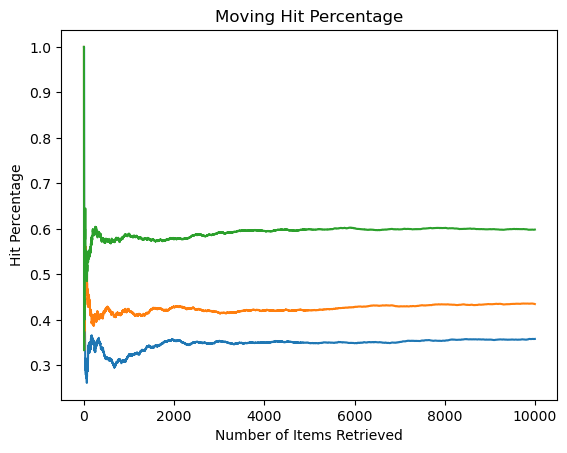

In [105]:
l1 = [50,100,400]
for k1 in l1:
    rv_zipf = zipf(1.0,np.size(names))
    k = k1 #Size of the Cache
    r = 10000 #Number of retrievals
    hits = 0. #Keeps track of the number of hits in the cache
    hit_av = [] #Keeps track of the hit average
    cache = []
    while np.size(cache) < k:                 
        rv = rv_zipf.rvs()-1   #Random variate from the zipf distribution
        item = names[rv]    #Item to be retrieved
        cache.append(item)
        
    for i in range(r):
        rv = rv_zipf.rvs()-1   #Random variate from the zipf distribution
        item = names[rv]    #Item to be retrieved
        if item in cache:
            cache = cache_hit(cache, item)
            hits = hits+1
        else:
            cache = cache_miss(cache, item)
        hit_av.append(hits/(i+1))

    plt.plot(hit_av)
    plt.title('Moving Hit Percentage')
    plt.xlabel('Number of Items Retrieved')
    plt.ylabel('Hit Percentage')
    print (f'Hit Percentage k = {k1}:', hit_av[np.size(hit_av)-1])

__Answer:__ Using random replacement policy, the hit rate is doubled but this is not a guarantee every time. Lower values of s make the distribution more skewed, a small number of items are highly likely to be requested, while most items are rarely or never requested. As s decreases, the hit percentages become more erratic, reflecting the fact that a few items dominate the cache hits while many items are rarely accessed. As k increases, the hit percentage increases because a larger cache can store more items that are likely to be requested. The state of the cache in this experiment can be viewed as a Markov process, since it depends on the previous state of the cache (the order in which items were accessed).

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 3</SPAN>**

## Lab Questions:

Make sure to complete all lab questions 1-3 for this weeks lab.

<div class="alert alert-block alert-warning"> 
## Academic Integrity Statement ##

By submitting the lab with this statement, you declare you have written up the lab entirely by yourself, including both code and markdown cells. You also agree that you should not share your code with anyone else. Any violation of the academic integrity requirement may cause an academic integrity report to be filed that could go into your student record. See <a href="https://provost.illinois.edu/policies/policies/academic-integrity/students-quick-reference-guide-to-academic-integrity/">Students' Quick Reference Guide to Academic Integrity</a> for more information. 